# Real dataset application
The Diabetes prediction dataset (available on [Diabetes prediction dataset | Kaggle](https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset?resource=download)) is a "collection of medical and demographic data from patients, along with their diabetes status (positive or negative)". Here the methods developed on the two previous toy datasets are tested on a real dataset to check the power of the algorithms.

In [1]:
#### Libraries import #### 

# Manipulation / processing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

# Local module for loading the optimization functions and other utilities
import optimizer as opt

# Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

## Dataset loading and small EDA

The dataset has a size of 100000 samples. In this part the full dataset is imported and then subsampled to include only a random 1% of the total sample, in order to show that just a 1000 subsample provides a faster execution, being in the meantime enough for reaching nice results.

In [2]:
#### Dataset loading ####
diabetes_df = pd.read_csv("diabetes_prediction_dataset.csv", sep = ',')
diabetes_df = diabetes_df.sample(frac = 0.01, random_state = 16) # Subsample of 0.01 (1000 elements)

In [3]:
#### Dimensionality ####

n, m =  diabetes_df.shape

print("sample size: {}".format(n))
print("Number of features: {}".format(m - 1))

sample size: 1000
Number of features: 8


In [4]:
diabetes_df.head(10)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
45659,Male,10.0,0,0,No Info,18.79,3.5,80,0
17115,Female,25.0,0,0,current,27.32,6.8,140,1
77085,Male,73.0,0,0,not current,28.48,6.5,155,1
30386,Female,3.0,0,0,No Info,20.01,6.1,90,0
55412,Male,0.8,0,0,No Info,11.47,4.5,200,0
68444,Male,28.0,0,0,former,27.32,3.5,158,0
19863,Female,2.0,0,0,No Info,14.38,6.2,140,0
97480,Female,29.0,0,0,No Info,27.32,4.8,100,0
12394,Male,14.0,0,0,No Info,19.97,6.5,200,0
39740,Female,33.0,0,0,never,25.37,6.1,126,0


Let's check now the presence of null values and the classes of out target variable, named "diabetes".

In [5]:
nans = diabetes_df.isnull().sum().sum()
classes = diabetes_df.diabetes.unique()

print("Number of null values: {}".format(nans))
print("Classes for the target variable: {}".format(classes))

Number of null values: 0
Classes for the target variable: [0 1]


The next cell cheks the type for all the columns of the dataset. It is possible to observe a non-numerical type cell, which must be converted to a numerical category type.

In [6]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 45659 to 95581
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               1000 non-null   object 
 1   age                  1000 non-null   float64
 2   hypertension         1000 non-null   int64  
 3   heart_disease        1000 non-null   int64  
 4   smoking_history      1000 non-null   object 
 5   bmi                  1000 non-null   float64
 6   HbA1c_level          1000 non-null   float64
 7   blood_glucose_level  1000 non-null   int64  
 8   diabetes             1000 non-null   int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 78.1+ KB


In [7]:
# String categorical columns conversion to numerical categories

for column in diabetes_df.columns:
  if pd.api.types.is_string_dtype(diabetes_df[column]):
    diabetes_df[column] = pd.factorize(diabetes_df[column])[0]

diabetes_df.head(10)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
45659,0,10.0,0,0,0,18.79,3.5,80,0
17115,1,25.0,0,0,1,27.32,6.8,140,1
77085,0,73.0,0,0,2,28.48,6.5,155,1
30386,1,3.0,0,0,0,20.01,6.1,90,0
55412,0,0.8,0,0,0,11.47,4.5,200,0
68444,0,28.0,0,0,3,27.32,3.5,158,0
19863,1,2.0,0,0,0,14.38,6.2,140,0
97480,1,29.0,0,0,0,27.32,4.8,100,0
12394,0,14.0,0,0,0,19.97,6.5,200,0
39740,1,33.0,0,0,4,25.37,6.1,126,0


## Feature selection
To further slim the problem, in this section the mutual information technique has been used to create a ranking of the most important features and select the top n in terms of importance.

In [8]:
# Features and target variable separation
X = diabetes_df.drop('diabetes', axis = 1)
y = diabetes_df['diabetes']

# Mutal information scores calculation for each feature
mi_scores = mutual_info_classif(X, y)

# Scores dataframe making and sorting
mi_scores_df = pd.DataFrame({'Feature': X.columns, 'mi_scores': mi_scores}).sort_values('mi_scores', ascending = False)

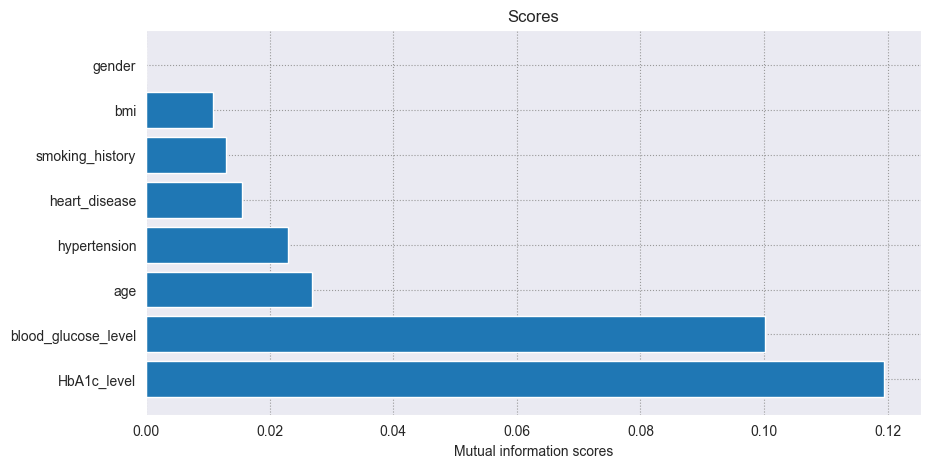

In [9]:
plt.figure(figsize=(10, 5))
plt.barh(y = mi_scores_df['Feature'], width = mi_scores_df['mi_scores'])
plt.xlabel('Mutual information scores')
plt.title("Scores")
plt.show()

In [10]:
to_keep = 4

mi_selector = SelectKBest(mutual_info_classif, k = to_keep)
X_kbest = mi_selector.fit_transform(X, y)

mask = mi_selector.get_support() # booleans
new_features = [] # k best features list

for bool, feature in zip(mask, X.columns):
  if bool:
    new_features.append(feature)

# The dataset is now updated discarding the worst features
diabetes_df = diabetes_df[new_features + ['diabetes']]

diabetes_df.head(10)

,age,bmi,HbA1c_level,blood_glucose_level,diabetes
45659,10.0,18.79,3.5,80,0
17115,25.0,27.32,6.8,140,1
77085,73.0,28.48,6.5,155,1
30386,3.0,20.01,6.1,90,0
55412,0.8,11.47,4.5,200,0
68444,28.0,27.32,3.5,158,0
19863,2.0,14.38,6.2,140,0
97480,29.0,27.32,4.8,100,0
12394,14.0,19.97,6.5,200,0
39740,33.0,25.37,6.1,126,0


## Problem building
In this section a specific percentage of labels is hidden for building the semi-supervised problem. Finally the weights are extracted.

In [11]:
# Semi-supervised problem building

n_samples = diabetes_df.shape[0] # Number of points to be generated
labeled_perc = 0.10 # Percentage of labeled points

n_labeled = int(labeled_perc * n_samples) # Number of labeled points
n_unlabeled = n_samples - n_labeled # Number of unlabeled points

print("Total number of points (2D): {}".format(n_samples))
print("Number of labeled points: {} ({} %)".format(n_labeled, 100 * labeled_perc))
print("Number of unlabeled points: {} ({} %)".format(n_unlabeled, 100 * (1 - labeled_perc)))

Total number of points (2D): 1000
Number of labeled points: 100 (10.0 %)
Number of unlabeled points: 900 (90.0 %)


In [12]:
# Points and labels subdivision
points = np.array(diabetes_df.drop('diabetes', axis = 1))
labels = np.array(diabetes_df['diabetes'])

# Labeled and unlabeled indices extraction
random_state = 16
labeled_indices = np.random.choice(n_samples, n_labeled, replace = False)
unlabeled_indices = np.setdiff1d(np.arange(n_samples), labeled_indices)

# Labeled and unlabeled data extraction
points_labeled = points[labeled_indices]
points_unlabeled = points[unlabeled_indices]

y_labeled = labels[labeled_indices]
y_unlabeled = labels[unlabeled_indices]

# Weights calculation (normalization, euclidian distance and similarity RBF kernel measure)
gamma = 3

weights_labeled_unlabeled, weights_unlabeled_unlabeled = opt.weights_extraction(points_unlabeled, points_labeled, gamma)

In [13]:
alpha = 5 # Regularization term for the Hessian matrix

H = opt.hessian_matrix(weights_labeled_unlabeled, weights_unlabeled_unlabeled, n_unlabeled, alpha)
L = opt.lipschitz_constant(H)
max_alpha = 1/L

print("Lipschitz constant value: {}".format(max_alpha))
print("Hessian condition number: {}".format(np.linalg.cond(H)))

Lipschitz constant value: 0.011068287167347023
Hessian condition number: 18.0696432045985


In [14]:
final_results = dict()

## Simple gradient descent
A simple gradient descent is performed in this section, using the concepts gained from the study performed on the synthetic dataset and on the toy dataset.

In [15]:
# Labels to be predicted are initialized randomly in the "y_unlabeled_init" vector, choosing randomly in the set [0, 1]
np.random.seed(16)
y_unlabeled_init = np.random.choice(classes, size = n_unlabeled)

In [16]:
# Iterations
num_iter = 75

# Learning rate
learning_rate = max_alpha

# Gradient descent function
y_unlabeled_optimized, losses, tot_time, accuracies = opt.gradient_descent(
  weights_labeled_unlabeled,
  weights_unlabeled_unlabeled,
  y_unlabeled_init,
  y_unlabeled,
  y_labeled,
  n_labeled,
  n_unlabeled,
  num_iter,
  learning_rate,
  verbose = True
  )

Execution progress: 0 %, Accuracy: 0.4978
Execution progress: 20 %, Accuracy: 0.8178
Execution progress: 40 %, Accuracy: 0.8689
Execution progress: 60 %, Accuracy: 0.9022
Execution progress: 80 %, Accuracy: 0.9233
Final accuracy: 0.9267


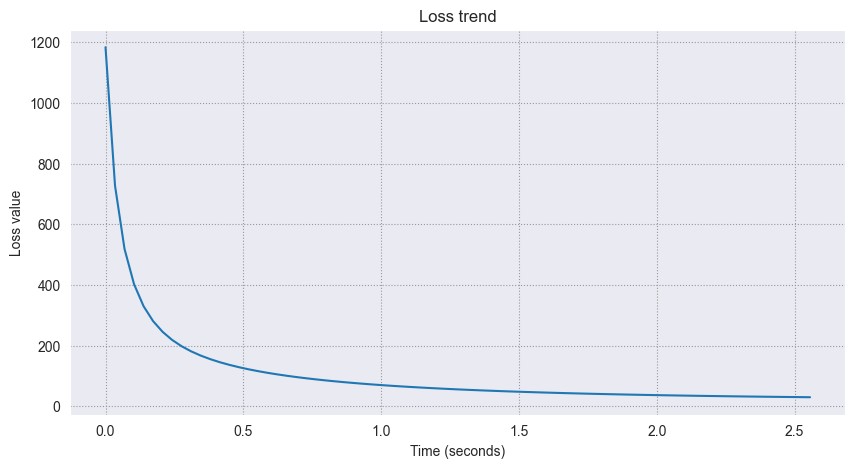

In [17]:
# Visualizing calculation time vs loss values
plt.figure(figsize = (10, 5))
plt.plot(np.linspace(0, tot_time, num = len(losses)), losses)

plt.xlabel("Time (seconds)")
plt.ylabel("Loss value")
plt.title("Loss trend")
plt.show()

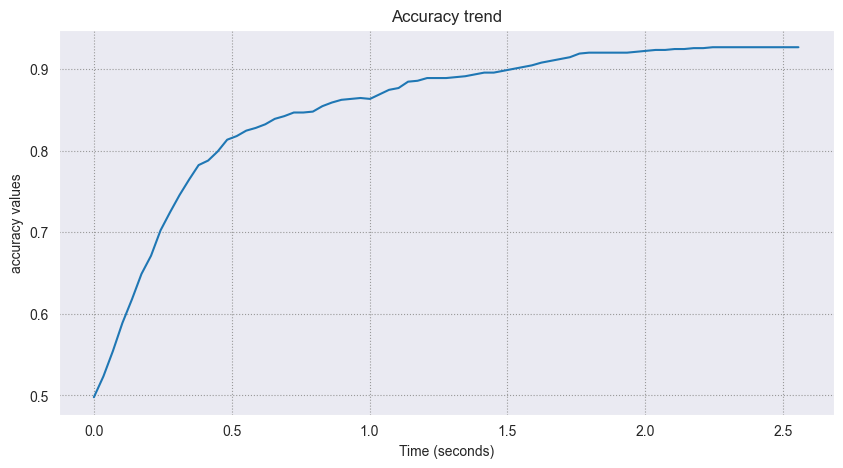

In [18]:
# Visualizing calculation time vs accuracy values
plt.figure(figsize = (10, 5))
plt.plot(np.linspace(0, tot_time, num = len(accuracies)), accuracies)

plt.xlabel("Time (seconds)")
plt.ylabel("accuracy values")
plt.title("Accuracy trend")
plt.show()

In [19]:
# Final results
print("Final time (seconds): {}".format(round(tot_time, 2)))
print("Final loss: {}".format(round(losses[-1], 4)))
print("Final accuracy: {}".format(round(accuracies[-1], 4)))

Final time (seconds): 2.56
Final loss: 29.9428
Final accuracy: 0.9267


In [20]:
final_results["GD"] = {"tot_time" : tot_time, "final_loss" : losses[-1], "final_accuracy" : accuracies[-1]}

## Block coordinate gradient descent
Also here, of course, the concepts gained from the previous study on the synthetic dataset and on the toy dataset are used.

In [21]:
# Labels to be predicted are initialized randomly in the "y_unlabeled_init" vector, choosing randomly in the set [0, 1]
n_unlabeled = len(y_unlabeled)
classes = [0, 1]

np.random.seed(16)
y_unlabeled_init = np.random.choice(classes, size = n_unlabeled)
y_unlabeled_init = y_unlabeled_init.astype(np.float64)

## Random permutation method

In [22]:
# Iterations
num_iter = 250

learning_rate = 10/L

block_size = 1

method = "random_permutation"

y_unlabeled_init_copy = y_unlabeled_init.copy()

y_unlabeled_optimized, losses, tot_time, accuracies = opt.block_coordinate_gradient_descent(
    weights_labeled_unlabeled,
    weights_unlabeled_unlabeled,
    y_unlabeled_init_copy,
    y_labeled,
    y_unlabeled,
    n_labeled,
    n_unlabeled,
    num_iter,
    learning_rate,
    block_size,
    method = method,
    verbose = True
    )

Execution progress: 0 %, Accuracy: 0.5389
Execution progress: 10 %, Accuracy: 0.8767
Execution progress: 20 %, Accuracy: 0.8944
Execution progress: 30 %, Accuracy: 0.9011
Execution progress: 40 %, Accuracy: 0.9056
Execution progress: 50 %, Accuracy: 0.9089
Execution progress: 60 %, Accuracy: 0.9078
Execution progress: 70 %, Accuracy: 0.9078
Execution progress: 80 %, Accuracy: 0.9078
Execution progress: 90 %, Accuracy: 0.9089
Final accuracy: 0.9111


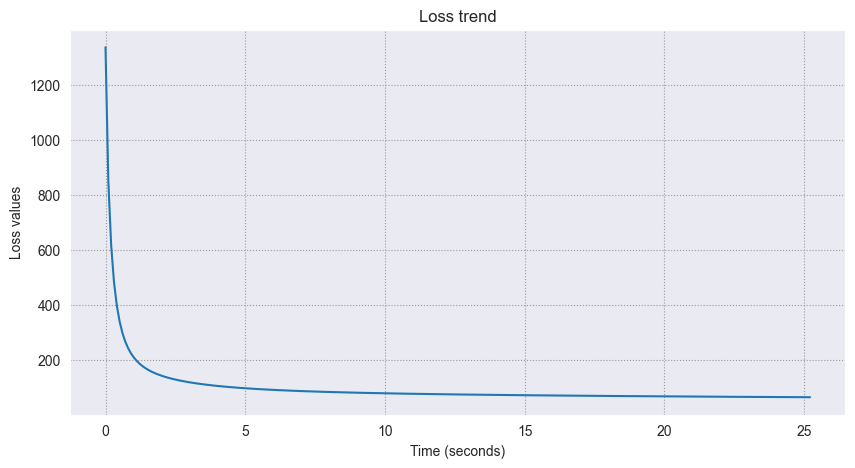

In [23]:
plt.figure(figsize = (10, 5))
plt.plot(np.linspace(0, tot_time, num = len(losses)), losses)

plt.xlabel("Time (seconds)")
plt.ylabel("Loss values")
plt.title("Loss trend")
plt.show()

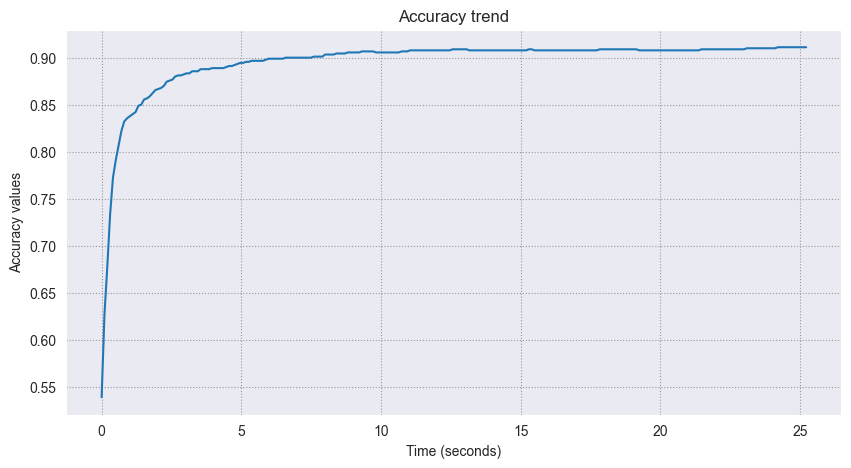

In [24]:
plt.figure(figsize = (10, 5))
plt.plot(np.linspace(0, tot_time, num = len(accuracies)), accuracies)

plt.xlabel("Time (seconds)")
plt.ylabel("Accuracy values")
plt.title("Accuracy trend")
plt.show()

In [25]:
# Final results
print("Final time (seconds): {}".format(round(tot_time, 2)))
print("Final loss: {}".format(round(losses[-1], 4)))
print("Final accuracy: {}".format(round(accuracies[-1], 4)))

Final time (seconds): 25.21
Final loss: 64.4134
Final accuracy: 0.9111


In [26]:
final_results["RP-BCGD"] = {"tot_time" : tot_time, "final_loss" : losses[-1], "final_accuracy" : accuracies[-1]}

## Gauss-Southwell method

In [27]:
# Iterations
num_iter = 5000

learning_rate = 15/L

block_size = 1

method = "gauss_southwell"

y_unlabeled_init_copy = y_unlabeled_init.copy()

y_unlabeled_optimized, losses, tot_time, accuracies = opt.block_coordinate_gradient_descent(
    weights_labeled_unlabeled,
    weights_unlabeled_unlabeled,
    y_unlabeled_init_copy,
    y_labeled,
    y_unlabeled,
    n_labeled,
    n_unlabeled,
    num_iter,
    learning_rate,
    block_size,
    method = method,
    verbose = True
    )

Execution progress: 0 %, Accuracy: 0.4967
Execution progress: 10 %, Accuracy: 0.6944
Execution progress: 20 %, Accuracy: 0.7778
Execution progress: 30 %, Accuracy: 0.8311
Execution progress: 40 %, Accuracy: 0.8422
Execution progress: 50 %, Accuracy: 0.8567
Execution progress: 60 %, Accuracy: 0.8667
Execution progress: 70 %, Accuracy: 0.88
Execution progress: 80 %, Accuracy: 0.8844
Execution progress: 90 %, Accuracy: 0.8889
Final accuracy: 0.8911


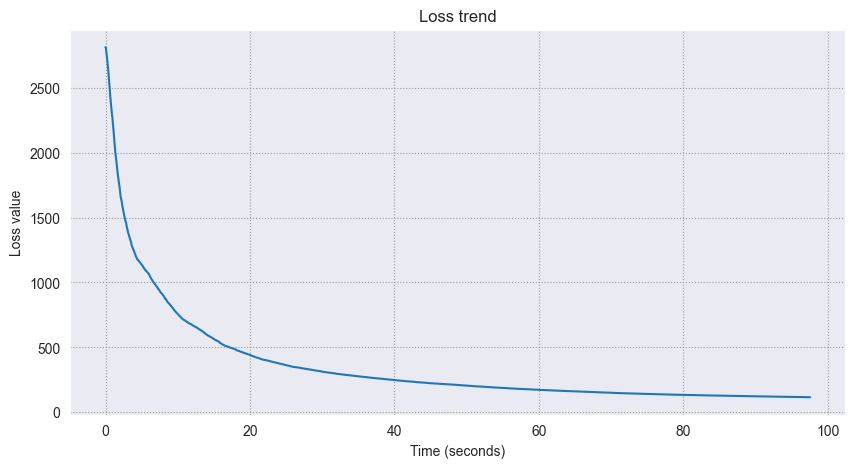

In [28]:
plt.figure(figsize = (10, 5))
plt.plot(np.linspace(0, tot_time, num = len(losses)), losses)

plt.xlabel("Time (seconds)")
plt.ylabel("Loss value")
plt.title("Loss trend")
plt.show()

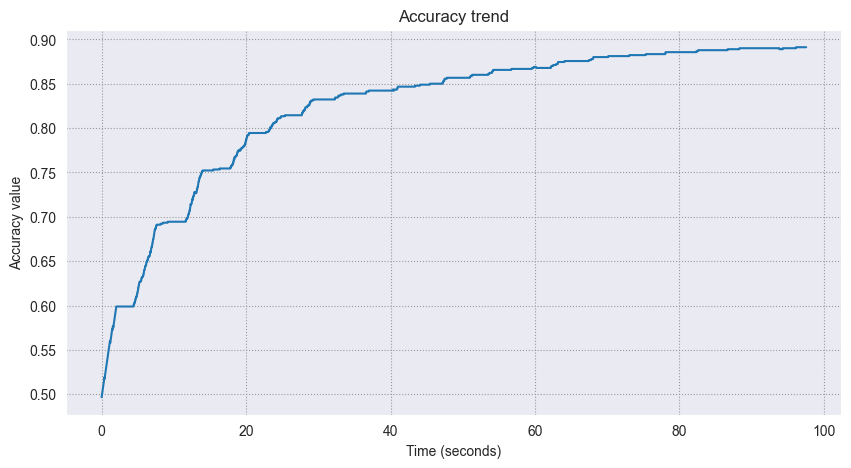

In [29]:
plt.figure(figsize = (10, 5))
plt.plot(np.linspace(0, tot_time, num = len(accuracies)), accuracies)

plt.xlabel("Time (seconds)")
plt.ylabel("Accuracy value")
plt.title("Accuracy trend")
plt.show()

In [30]:
# Final results
print("Final time (seconds): {}".format(round(tot_time, 2)))
print("Final loss: {}".format(round(losses[-1], 4)))
print("Final accuracy: {}".format(round(accuracies[-1], 4)))

Final time (seconds): 97.55
Final loss: 116.3696
Final accuracy: 0.8911


In [31]:
final_results["GS-BCGD"] = {"tot_time" : tot_time, "final_loss" : losses[-1], "final_accuracy" : accuracies[-1]}

# Final results

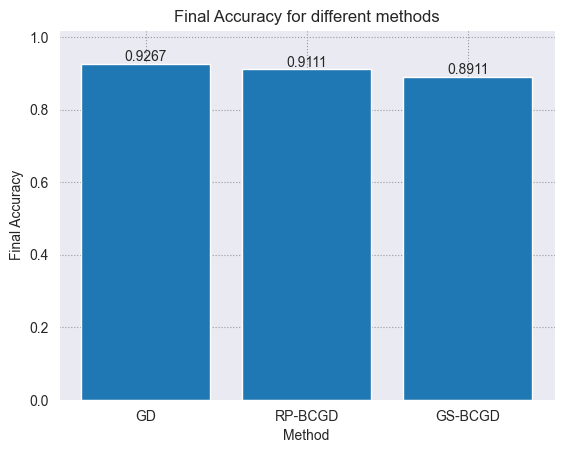

In [32]:
# Accuracies plot
to_plot = "final_accuracy"

names = list(final_results.keys())
values = [sub_dict[to_plot] for sub_dict in final_results.values()]

bars = plt.bar(names, values)
plt.ylim([0, max(values) * 1.1])

# Add labels, title and legend
plt.xlabel("Method")
plt.ylabel("Final Accuracy")
plt.title("Final Accuracy for different methods")

# This loop add the values on top of each bar
for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 4), va = "bottom", ha = "center") 

plt.show()
